# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [45]:
# Load the libraries as required.
# Data handling and visualization
import pandas as pd
import numpy as np

# Scikit-learn model building and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Regressor models
from sklearn.neighbors import KNeighborsRegressor  # Baseline regressor
from sklearn.ensemble import RandomForestRegressor  # Advanced regressor

# Model evaluation metrics
from sklearn.metrics import mean_squared_error

import pickle
import shap 

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [6]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))


# Get X and Y

Create the features data frame and target data.

In [9]:
X = fires_dt.drop(columns='area')
Y = fires_dt['area']
# Display the first few rows of the features and target to confirm
print("\nFeatures DataFrame (X):")
print(X.head())

print("\nTarget Variable (y):")
print(Y.head())


Features DataFrame (X):
   coord_x  coord_y month  day  ffmc   dmc     dc  isi  temp  rh  wind  rain
0        7        5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0
1        7        4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0
2        7        4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0
3        8        6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2
4        8        6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0

Target Variable (y):
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: area, dtype: float64


In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [29]:
# Define numerical and categorical feature lists
numerical_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_features = ['month', 'day']

# Create preproc1: standard scaling for numerical, one-hot encoding for categorical features
preproc1 = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_features),  # Standard scaling for numerical features
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encoding for categorical features
    ]
)



### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [30]:
# Define the non-linear transformation (e.g., log transformation) for selected numerical features
log_transformer = FunctionTransformer(np.log1p, validate=True)  # Applies log(1 + x)

# Create preproc2: scaling with Min-Max, log transformation, and one-hot encoding
preproc2 = ColumnTransformer(
    transformers=[
        ('num_scaler', MinMaxScaler(), numerical_features),  # Min-Max scaling for numerical features
        ('num_log_transform', log_transformer, numerical_features),  # Log transformation for numerical features
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encoding for categorical features
    ]
)

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [31]:
# Pipeline A = preproc1 + baseline
# Define the baseline and advanced models
baseline_model = KNeighborsRegressor(n_neighbors=5)  # Baseline regressor: KNN with 5 neighbors
advanced_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Advanced regressor: Random Forest

# Pipeline A: preproc1 + baseline model
pipeline_A = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', baseline_model)
])

In [32]:
# Pipeline B = preproc2 + baseline
pipeline_B = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', baseline_model)
])

In [33]:
# Pipeline C = preproc1 + advanced model
pipeline_C = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', advanced_model)
])

In [34]:
# Pipeline D = preproc2 + advanced model
pipeline_D = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', advanced_model)
])
    

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [35]:
param_grid_A = {
    'regressor__n_neighbors': [3, 5, 7, 9]  # Tuning KNN 'n_neighbors'
}

In [36]:
param_grid_B = {
    'regressor__n_neighbors': [3, 5, 7, 9]  # Tuning KNN 'n_neighbors'
}

In [37]:
param_grid_C = {
    'regressor__n_estimators': [50, 100, 150, 200],  # Tuning RandomForest 'n_estimators'
    'regressor__max_depth': [None, 10, 20, 30]  # Tuning RandomForest 'max_depth'
}

In [38]:
param_grid_D = {
    'regressor__n_estimators': [50, 100, 150, 200],  # Tuning RandomForest 'n_estimators'
    'regressor__max_depth': [None, 10, 20, 30]  # Tuning RandomForest 'max_depth'
}

In [41]:
# GridSearch for Pipeline A (preproc1 + KNN)
grid_search_A = GridSearchCV(pipeline_A, param_grid_A, cv=5, scoring='neg_mean_squared_error')
grid_search_A.fit(X_train, Y_train)

# GridSearch for Pipeline B (preproc2 + KNN)
grid_search_B = GridSearchCV(pipeline_B, param_grid_B, cv=5, scoring='neg_mean_squared_error')
grid_search_B.fit(X_train, Y_train)

# GridSearch for Pipeline C (preproc1 + Random Forest)
grid_search_C = GridSearchCV(pipeline_C, param_grid_C, cv=5, scoring='neg_mean_squared_error')
grid_search_C.fit(X_train, Y_train)

# GridSearch for Pipeline D (preproc2 + Random Forest)
grid_search_D = GridSearchCV(pipeline_D, param_grid_D, cv=5, scoring='neg_mean_squared_error')
grid_search_D.fit(X_train, Y_train)



# Print best parameters and scores for each pipeline
print("Best Parameters for Pipeline A:", grid_search_A.best_params_)
print("Best Score for Pipeline A:", -grid_search_A.best_score_)

print("Best Parameters for Pipeline B:", grid_search_B.best_params_)
print("Best Score for Pipeline B:", -grid_search_B.best_score_)

print("Best Parameters for Pipeline C:", grid_search_C.best_params_)
print("Best Score for Pipeline C:", -grid_search_C.best_score_)

print("Best Parameters for Pipeline D:", grid_search_D.best_params_)
print("Best Score for Pipeline D:", -grid_search_D.best_score_)


# Identify the best performing model
best_score = min(-grid_search_A.best_score_, -grid_search_B.best_score_, -grid_search_C.best_score_, -grid_search_D.best_score_)

if best_score == -grid_search_A.best_score_:
    best_pipeline = grid_search_A
    best_name = "Pipeline A"
elif best_score == -grid_search_B.best_score_:
    best_pipeline = grid_search_B
    best_name = "Pipeline B"
elif best_score == -grid_search_C.best_score_:
    best_pipeline = grid_search_C
    best_name = "Pipeline C"
else:
    best_pipeline = grid_search_D
    best_name = "Pipeline D"

print(f"The best performing model is {best_name} with a mean squared error of {best_score:.4f}")



Best Parameters for Pipeline A: {'regressor__n_neighbors': 9}
Best Score for Pipeline A: 2537.6688250265897
Best Parameters for Pipeline B: {'regressor__n_neighbors': 9}
Best Score for Pipeline B: 2657.5103842880094
Best Parameters for Pipeline C: {'regressor__max_depth': None, 'regressor__n_estimators': 200}
Best Score for Pipeline C: 3045.7251422005766
Best Parameters for Pipeline D: {'regressor__max_depth': 10, 'regressor__n_estimators': 200}
Best Score for Pipeline D: 3026.571309100066
The best performing model is Pipeline A with a mean squared error of 2537.6688


# Evaluate

+ Which model has the best performance? The best performing model is Pipeline A with a mean squared error of 2537.6688

# Export

+ Save the best performing model to a pickle file.

In [43]:
# Assuming 'best_model' is the best-performing model obtained from the grid search

# Save the best performing model to a pickle file
with open('best_model_pipeline.pkl', 'wb') as model_file:
    pickle.dump(best_pipeline.best_estimator_, model_file)

print("Best performing model saved as best_model_pipeline.pkl")


Best performing model saved as best_model_pipeline.pkl


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


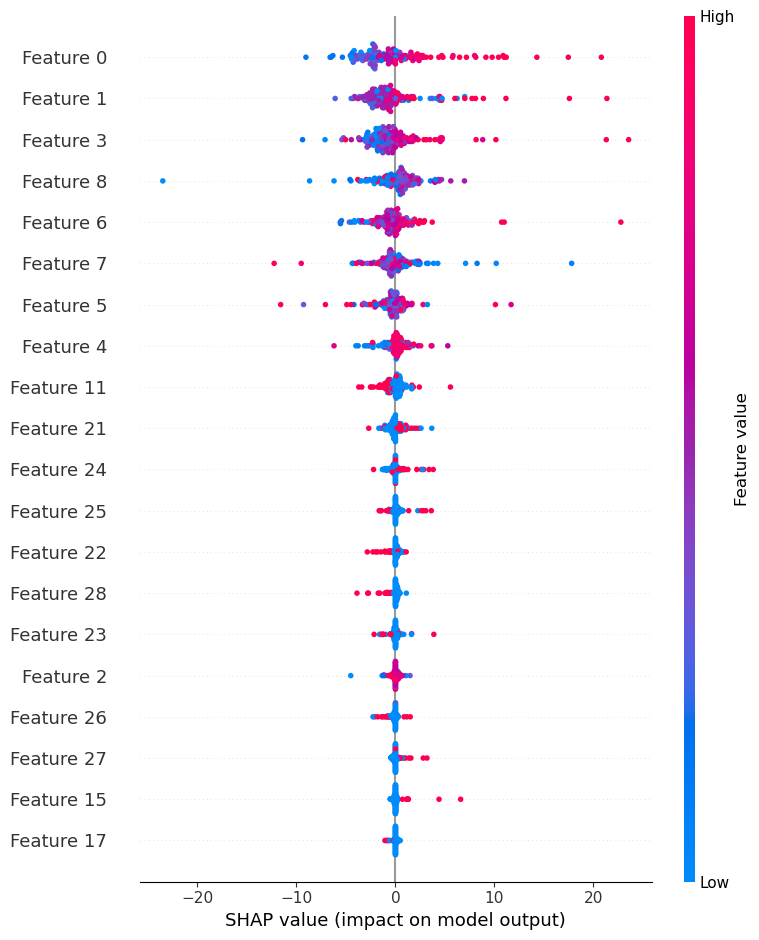

In [47]:
# Fit the best pipeline model retrieved from grid search
best_pipeline = grid_search_A.best_estimator_  # Replace with the appropriate grid search result
best_pipeline.fit(X_train, Y_train)

# Transform the test set with the preprocessing step in the pipeline
X_test_processed = best_pipeline.named_steps['preprocessing'].transform(X_test)

# Sample a subset of the training data for use as a background dataset
X_train_sample = shap.sample(X_train, 100)  # Adjust the sample size as needed
X_train_sample_processed = best_pipeline.named_steps['preprocessing'].transform(X_train_sample)

# Create a SHAP KernelExplainer for the KNeighborsRegressor
shap_explainer = shap.KernelExplainer(best_pipeline.named_steps['regressor'].predict, X_train_sample_processed)

# Compute SHAP values for a subset of the test set
shap_values_test = shap_explainer.shap_values(X_test_processed)

# Select an observation to explain (e.g., first observation)
sample_index = 0
sample_shap_values = shap_explainer.shap_values(X_test_processed[sample_index:sample_index + 1])

# Visualize the SHAP force plot for the selected observation
shap.initjs()
shap.force_plot(shap_explainer.expected_value, sample_shap_values, X_test_processed[sample_index])

# Visualize global feature importance
shap.summary_plot(shap_values_test, X_test_processed)


*(Answer here.)*

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.